<a href="https://colab.research.google.com/github/dla9944/God_damn_deeplearning/blob/master/Tacos%26Burrito_image_%EC%B2%98%EB%A6%AC_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# pytorch 라이브러리
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch import nn, optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import utils
# 시각화 관련

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib import cm 

# arange 기본
import numpy as np
import pandas as pd

# image convertor
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 그외

import os
import random
import tqdm

In [36]:
# gpu 사용

USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")
from sklearn.datasets import load_digits
digits = load_digits()

Using Device : cuda


In [15]:
# 타코와 부리또 구분 처리

!wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
!tar -zxvf taco_and_burrito.tar.gz


--2023-01-24 02:08:25--  https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz [following]
--2023-01-24 02:08:25--  https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292798 (15M) [application/octet-stream]
Saving to: ‘taco_and_burrito.tar.gz’

taco_and_burrito.ta 100%[===================>]  14.58M  --.-KB/s    in 0.08s   

2023-01-24 02:08:26 (193 MB

In [29]:
# dataset 작성
train_imgs = ImageFolder('/content/taco_and_burrito/train/',
                         transform = transforms.Compose([
                             transforms.RandomCrop(224),
                             transforms.ToTensor()
                         ]))
test_imgs = ImageFolder('/content/taco_and_burrito/test/',
                         transform = transforms.Compose([
                             transforms.RandomCrop(224),
                             transforms.ToTensor()
                         ]))

train_loader = DataLoader(train_imgs, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_imgs, batch_size = 32, shuffle = False)

In [31]:
print(train_imgs.classes), print(train_imgs.class_to_idx)

['burrito', 'taco']
{'burrito': 0, 'taco': 1}


(None, None)

(3, 896, 1792)


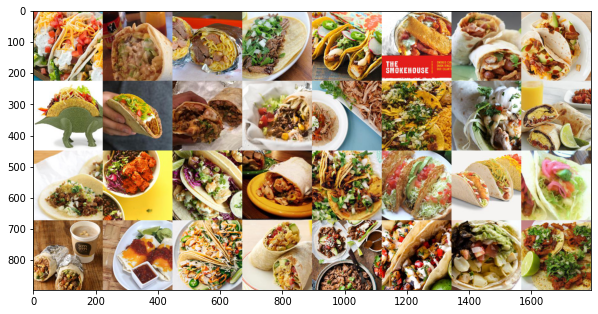

In [55]:
# 학습 데이터 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
print(npimg.shape)
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

(3, 896, 1792)


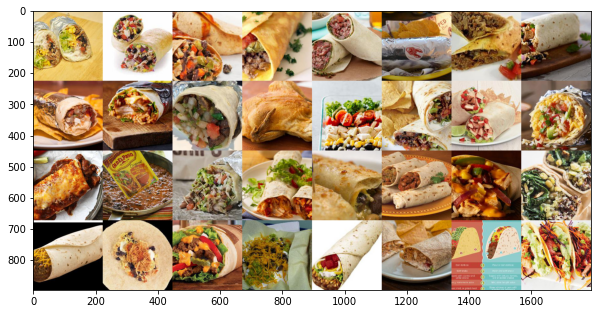

In [53]:
# 평가 데이터 확인
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
print(npimg.shape)
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [33]:
# Resnet 미리 저장된 모델을 로드

net = models.resnet18(pretrained = True)

for p in net.parameters():
    p.requires_grad = False

# 마지막 계층만 변경
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [44]:
# 모델 훈련 함수 제작

def eval_net(net, data_loader, device = device):
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _, y_pred = net(x).max(1)
            ys.append(y)
            ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)

    accuracy = (ys == ypreds).float().sum()/len(ys)
    return accuracy.item()

def train_net(net, train_loader, test_loader, only_fc = True,
              optimizer = optim.Adam, loss_function = nn.CrossEntropyLoss(),
              n_iter = 10, device = device):
    train_losses = []
    train_accuracy = []
    val_accuracy = []
    if only_fc:
       optimizer = optimizer(net.fc.parameters())
    else: # 마지막 선형 계층의 패러미터만 optimizer 전달
       optimizer = optimizer(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        net.train()
        n = 0
        n_accuracy = 0
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total = len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_function(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n = n + len(xx)
            _, y_pred = h.max(1)
            n_accuracy += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        train_accuracy.append(n_accuracy / n)

        val_accuracy.append(eval_net(net, test_loader, device))

        print(f'epoch 횟수 = {epoch}, 학습 loss = {train_losses[-1]:.4f}, 학습 정확도 = {train_accuracy[-1]:.4f},검증 정확도 = {val_accuracy[-1]:.4f}',
              flush = True)

In [41]:
net.to(device)

# gpu에서 훈련 시작
train_net(net, train_loader, test_loader, n_iter = 20, device = device)


100%|██████████| 23/23 [00:02<00:00,  9.46it/s]


epoch 횟수 = 0, 학습 loss = 0.33478397808291693, 학습 정확도 = 0.8525280898876404,검증 정확도 = 0.8500000238418579


100%|██████████| 23/23 [00:02<00:00,  9.66it/s]


epoch 횟수 = 1, 학습 loss = 0.29624525864015927, 학습 정확도 = 0.8778089887640449,검증 정확도 = 0.8666667342185974


100%|██████████| 23/23 [00:02<00:00,  9.56it/s]


epoch 횟수 = 2, 학습 loss = 0.2999632263725454, 학습 정확도 = 0.8806179775280899,검증 정확도 = 0.8666667342185974


100%|██████████| 23/23 [00:02<00:00,  9.82it/s]


epoch 횟수 = 3, 학습 loss = 0.28396605022928934, 학습 정확도 = 0.8960674157303371,검증 정확도 = 0.8833333849906921


100%|██████████| 23/23 [00:02<00:00,  9.72it/s]


epoch 횟수 = 4, 학습 loss = 0.2667978053743189, 학습 정확도 = 0.8946629213483146,검증 정확도 = 0.8333333730697632


100%|██████████| 23/23 [00:02<00:00,  9.28it/s]


epoch 횟수 = 5, 학습 loss = 0.27223747020417993, 학습 정확도 = 0.8890449438202247,검증 정확도 = 0.8333333730697632


100%|██████████| 23/23 [00:03<00:00,  7.65it/s]


epoch 횟수 = 6, 학습 loss = 0.29488838531754236, 학습 정확도 = 0.8834269662921348,검증 정확도 = 0.8333333730697632


100%|██████████| 23/23 [00:02<00:00,  9.47it/s]


epoch 횟수 = 7, 학습 loss = 0.28908270529725333, 학습 정확도 = 0.8904494382022472,검증 정확도 = 0.8166667222976685


100%|██████████| 23/23 [00:02<00:00,  9.43it/s]


epoch 횟수 = 8, 학습 loss = 0.31309042600068177, 학습 정확도 = 0.8721910112359551,검증 정확도 = 0.8333333730697632


100%|██████████| 23/23 [00:02<00:00,  9.53it/s]


epoch 횟수 = 9, 학습 loss = 0.27746476470069453, 학습 정확도 = 0.8904494382022472,검증 정확도 = 0.8500000238418579


100%|██████████| 23/23 [00:02<00:00,  9.25it/s]


epoch 횟수 = 10, 학습 loss = 0.25614018738269806, 학습 정확도 = 0.8946629213483146,검증 정확도 = 0.8500000238418579


100%|██████████| 23/23 [00:02<00:00,  9.22it/s]


epoch 횟수 = 11, 학습 loss = 0.25925886021419003, 학습 정확도 = 0.8890449438202247,검증 정확도 = 0.8666667342185974


100%|██████████| 23/23 [00:02<00:00,  9.52it/s]


epoch 횟수 = 12, 학습 loss = 0.29875802688977937, 학습 정확도 = 0.8918539325842697,검증 정확도 = 0.8666667342185974


100%|██████████| 23/23 [00:02<00:00,  9.41it/s]


epoch 횟수 = 13, 학습 loss = 0.27895856580950995, 학습 정확도 = 0.8792134831460674,검증 정확도 = 0.8333333730697632


100%|██████████| 23/23 [00:02<00:00,  9.41it/s]


epoch 횟수 = 14, 학습 loss = 0.2612262544306842, 학습 정확도 = 0.9087078651685393,검증 정확도 = 0.8333333730697632


100%|██████████| 23/23 [00:02<00:00,  9.50it/s]


epoch 횟수 = 15, 학습 loss = 0.2758887206966227, 학습 정확도 = 0.8974719101123596,검증 정확도 = 0.8666667342185974


100%|██████████| 23/23 [00:02<00:00,  9.44it/s]


epoch 횟수 = 16, 학습 loss = 0.282127626917579, 학습 정확도 = 0.8890449438202247,검증 정확도 = 0.8500000238418579


100%|██████████| 23/23 [00:02<00:00,  9.52it/s]


epoch 횟수 = 17, 학습 loss = 0.2724051075902852, 학습 정확도 = 0.8960674157303371,검증 정확도 = 0.9000000357627869


100%|██████████| 23/23 [00:02<00:00,  9.67it/s]


epoch 횟수 = 18, 학습 loss = 0.2472429173913869, 학습 정확도 = 0.9087078651685393,검증 정확도 = 0.8833333849906921


100%|██████████| 23/23 [00:02<00:00,  9.65it/s]


epoch 횟수 = 19, 학습 loss = 0.23744373226707632, 학습 정확도 = 0.9030898876404494,검증 정확도 = 0.8500000238418579


In [45]:
net.to(device)

# gpu에서 훈련 시작
train_net(net, train_loader, test_loader, n_iter = 50, device = device)


100%|██████████| 23/23 [00:02<00:00,  9.29it/s]


epoch 횟수 = 0, 학습 loss = 0.2324, 학습 정확도 = 0.9115,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:03<00:00,  7.14it/s]


epoch 횟수 = 1, 학습 loss = 0.2283, 학습 정확도 = 0.9101,검증 정확도 = 0.8833


100%|██████████| 23/23 [00:02<00:00,  9.11it/s]


epoch 횟수 = 2, 학습 loss = 0.2249, 학습 정확도 = 0.9101,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  8.72it/s]


epoch 횟수 = 3, 학습 loss = 0.2256, 학습 정확도 = 0.9073,검증 정확도 = 0.7833


100%|██████████| 23/23 [00:02<00:00,  8.61it/s]


epoch 횟수 = 4, 학습 loss = 0.2496, 학습 정확도 = 0.8904,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  8.87it/s]


epoch 횟수 = 5, 학습 loss = 0.2312, 학습 정확도 = 0.9213,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.36it/s]


epoch 횟수 = 6, 학습 loss = 0.2535, 학습 정확도 = 0.8933,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.62it/s]


epoch 횟수 = 7, 학습 loss = 0.2325, 학습 정확도 = 0.9157,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.70it/s]


epoch 횟수 = 8, 학습 loss = 0.2509, 학습 정확도 = 0.8933,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.47it/s]


epoch 횟수 = 9, 학습 loss = 0.2200, 학습 정확도 = 0.9045,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  8.87it/s]


epoch 횟수 = 10, 학습 loss = 0.2190, 학습 정확도 = 0.9171,검증 정확도 = 0.8833


100%|██████████| 23/23 [00:02<00:00,  9.75it/s]


epoch 횟수 = 11, 학습 loss = 0.2486, 학습 정확도 = 0.9045,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


epoch 횟수 = 12, 학습 loss = 0.2507, 학습 정확도 = 0.9101,검증 정확도 = 0.7833


100%|██████████| 23/23 [00:02<00:00,  9.61it/s]


epoch 횟수 = 13, 학습 loss = 0.2299, 학습 정확도 = 0.9073,검증 정확도 = 0.8833


100%|██████████| 23/23 [00:02<00:00,  9.59it/s]


epoch 횟수 = 14, 학습 loss = 0.2626, 학습 정확도 = 0.9115,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  9.42it/s]


epoch 횟수 = 15, 학습 loss = 0.2538, 학습 정확도 = 0.9031,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.09it/s]


epoch 횟수 = 16, 학습 loss = 0.1927, 학습 정확도 = 0.9185,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.49it/s]


epoch 횟수 = 17, 학습 loss = 0.2012, 학습 정확도 = 0.9213,검증 정확도 = 0.8000


100%|██████████| 23/23 [00:02<00:00,  9.36it/s]


epoch 횟수 = 18, 학습 loss = 0.2326, 학습 정확도 = 0.9045,검증 정확도 = 0.8833


100%|██████████| 23/23 [00:02<00:00,  9.60it/s]


epoch 횟수 = 19, 학습 loss = 0.2341, 학습 정확도 = 0.9017,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.54it/s]


epoch 횟수 = 20, 학습 loss = 0.2185, 학습 정확도 = 0.9157,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.69it/s]


epoch 횟수 = 21, 학습 loss = 0.2910, 학습 정확도 = 0.8890,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.51it/s]


epoch 횟수 = 22, 학습 loss = 0.2226, 학습 정확도 = 0.9312,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.49it/s]


epoch 횟수 = 23, 학습 loss = 0.2256, 학습 정확도 = 0.9003,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.49it/s]


epoch 횟수 = 24, 학습 loss = 0.2337, 학습 정확도 = 0.9017,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  8.62it/s]


epoch 횟수 = 25, 학습 loss = 0.2457, 학습 정확도 = 0.8975,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.45it/s]


epoch 횟수 = 26, 학습 loss = 0.2555, 학습 정확도 = 0.8989,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.09it/s]


epoch 횟수 = 27, 학습 loss = 0.1913, 학습 정확도 = 0.9340,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.46it/s]


epoch 횟수 = 28, 학습 loss = 0.2445, 학습 정확도 = 0.9087,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.45it/s]


epoch 횟수 = 29, 학습 loss = 0.2377, 학습 정확도 = 0.9059,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.48it/s]


epoch 횟수 = 30, 학습 loss = 0.2021, 학습 정확도 = 0.9284,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  9.84it/s]


epoch 횟수 = 31, 학습 loss = 0.2225, 학습 정확도 = 0.9143,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.67it/s]


epoch 횟수 = 32, 학습 loss = 0.2218, 학습 정확도 = 0.9157,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.46it/s]


epoch 횟수 = 33, 학습 loss = 0.2247, 학습 정확도 = 0.9228,검증 정확도 = 0.8000


100%|██████████| 23/23 [00:02<00:00,  9.45it/s]


epoch 횟수 = 34, 학습 loss = 0.2406, 학습 정확도 = 0.9003,검증 정확도 = 0.8000


100%|██████████| 23/23 [00:02<00:00,  9.49it/s]


epoch 횟수 = 35, 학습 loss = 0.2232, 학습 정확도 = 0.9045,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  9.42it/s]


epoch 횟수 = 36, 학습 loss = 0.1939, 학습 정확도 = 0.9270,검증 정확도 = 0.8167


100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


epoch 횟수 = 37, 학습 loss = 0.2500, 학습 정확도 = 0.9003,검증 정확도 = 0.9000


100%|██████████| 23/23 [00:03<00:00,  6.86it/s]


epoch 횟수 = 38, 학습 loss = 0.2090, 학습 정확도 = 0.9157,검증 정확도 = 0.8000


100%|██████████| 23/23 [00:02<00:00,  7.73it/s]


epoch 횟수 = 39, 학습 loss = 0.2702, 학습 정확도 = 0.8989,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:03<00:00,  6.92it/s]


epoch 횟수 = 40, 학습 loss = 0.1962, 학습 정확도 = 0.9199,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  9.01it/s]


epoch 횟수 = 41, 학습 loss = 0.2256, 학습 정확도 = 0.9185,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:02<00:00,  8.72it/s]


epoch 횟수 = 42, 학습 loss = 0.2264, 학습 정확도 = 0.9115,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:03<00:00,  7.40it/s]


epoch 횟수 = 43, 학습 loss = 0.2328, 학습 정확도 = 0.9115,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:03<00:00,  7.39it/s]


epoch 횟수 = 44, 학습 loss = 0.2368, 학습 정확도 = 0.9045,검증 정확도 = 0.8667


100%|██████████| 23/23 [00:02<00:00,  8.05it/s]


epoch 횟수 = 45, 학습 loss = 0.2071, 학습 정확도 = 0.9115,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:03<00:00,  7.53it/s]


epoch 횟수 = 46, 학습 loss = 0.2139, 학습 정확도 = 0.9129,검증 정확도 = 0.8333


100%|██████████| 23/23 [00:03<00:00,  7.07it/s]


epoch 횟수 = 47, 학습 loss = 0.2018, 학습 정확도 = 0.9256,검증 정확도 = 0.8833


100%|██████████| 23/23 [00:02<00:00,  8.05it/s]


epoch 횟수 = 48, 학습 loss = 0.2038, 학습 정확도 = 0.9284,검증 정확도 = 0.8500


100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


epoch 횟수 = 49, 학습 loss = 0.2085, 학습 정확도 = 0.9199,검증 정확도 = 0.8333


In [46]:
# 입력을 그대로 출력해서 더미 계층을 만들어 fc를 변경

class FlattenLayer(nn.Module):
   def forward(self, x):
       sizes = x.size()
       return x.view(sizes[0], -1)

class IdentityLayer(nn.Module):
   def forward(self, x):
       return x

In [47]:
net = models.resnet18(pretrained = True)
for p in net.parameters():
    p.requires_grad = False
net.fc = IdentityLayer()

In [48]:
cnn_NET = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    FlattenLayer()
)

test_input = torch.ones(1, 3, 224, 224)
conv_output_size = cnn_NET(test_input).size()[-1]

net = nn.Sequential(
    cnn_NET,
    nn.Linear(conv_output_size, 2)
)

net.to(device)
train_net(net, train_loader, test_loader, n_iter = 20, only_fc = False,
          device = device)

100%|██████████| 23/23 [00:03<00:00,  6.36it/s]


epoch 횟수 = 0, 학습 loss = 4.7433, 학습 정확도 = 0.5801,검증 정확도 = 0.5000


100%|██████████| 23/23 [00:02<00:00,  7.80it/s]


epoch 횟수 = 1, 학습 loss = 5.1039, 학습 정확도 = 0.6081,검증 정확도 = 0.6333


100%|██████████| 23/23 [00:02<00:00,  7.81it/s]


epoch 횟수 = 2, 학습 loss = 4.8113, 학습 정확도 = 0.6292,검증 정확도 = 0.4833


100%|██████████| 23/23 [00:03<00:00,  7.08it/s]


epoch 횟수 = 3, 학습 loss = 4.6396, 학습 정확도 = 0.6124,검증 정확도 = 0.6000


100%|██████████| 23/23 [00:03<00:00,  7.64it/s]


epoch 횟수 = 4, 학습 loss = 5.4874, 학습 정확도 = 0.6236,검증 정확도 = 0.6000


100%|██████████| 23/23 [00:02<00:00,  7.78it/s]


epoch 횟수 = 5, 학습 loss = 5.1092, 학습 정확도 = 0.6138,검증 정확도 = 0.6333


100%|██████████| 23/23 [00:02<00:00,  7.90it/s]


epoch 횟수 = 6, 학습 loss = 4.6364, 학습 정확도 = 0.6419,검증 정확도 = 0.7167


100%|██████████| 23/23 [00:02<00:00,  7.91it/s]


epoch 횟수 = 7, 학습 loss = 5.7045, 학습 정확도 = 0.6166,검증 정확도 = 0.6333


100%|██████████| 23/23 [00:03<00:00,  7.41it/s]


epoch 횟수 = 8, 학습 loss = 6.4859, 학습 정확도 = 0.6110,검증 정확도 = 0.6167


100%|██████████| 23/23 [00:03<00:00,  7.36it/s]


epoch 횟수 = 9, 학습 loss = 6.0885, 학습 정확도 = 0.6236,검증 정확도 = 0.6000


100%|██████████| 23/23 [00:02<00:00,  7.89it/s]


epoch 횟수 = 10, 학습 loss = 5.7285, 학습 정확도 = 0.6545,검증 정확도 = 0.6333


100%|██████████| 23/23 [00:02<00:00,  7.89it/s]


epoch 횟수 = 11, 학습 loss = 4.3126, 학습 정확도 = 0.6390,검증 정확도 = 0.6500


100%|██████████| 23/23 [00:02<00:00,  7.91it/s]


epoch 횟수 = 12, 학습 loss = 4.4315, 학습 정확도 = 0.6601,검증 정확도 = 0.5833


100%|██████████| 23/23 [00:02<00:00,  7.89it/s]


epoch 횟수 = 13, 학습 loss = 4.7830, 학습 정확도 = 0.6573,검증 정확도 = 0.7667


100%|██████████| 23/23 [00:03<00:00,  7.54it/s]


epoch 횟수 = 14, 학습 loss = 3.9323, 학습 정확도 = 0.6671,검증 정확도 = 0.7333


100%|██████████| 23/23 [00:03<00:00,  6.31it/s]


epoch 횟수 = 15, 학습 loss = 4.2984, 학습 정확도 = 0.6728,검증 정확도 = 0.5667


100%|██████████| 23/23 [00:02<00:00,  7.89it/s]


epoch 횟수 = 16, 학습 loss = 4.9037, 학습 정확도 = 0.6615,검증 정확도 = 0.6667


100%|██████████| 23/23 [00:02<00:00,  7.83it/s]


epoch 횟수 = 17, 학습 loss = 4.1036, 학습 정확도 = 0.6320,검증 정확도 = 0.6167


100%|██████████| 23/23 [00:02<00:00,  7.87it/s]


epoch 횟수 = 18, 학습 loss = 3.7367, 학습 정확도 = 0.6798,검증 정확도 = 0.6167


100%|██████████| 23/23 [00:02<00:00,  7.88it/s]


epoch 횟수 = 19, 학습 loss = 5.6543, 학습 정확도 = 0.6348,검증 정확도 = 0.7000
